In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../imports/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


## Panel A <br>
Data requirement: presentation score matrices for all peptide classes, patient mutation matrix

In [2]:
categories = ['oncogenes', 'tsgenes', 'random',  'common', 'viral', 'bacterial']

In [3]:
mutation_counts = pd.DataFrame(pd.read_csv('../../data/patient_mutations.cancer.csv', index_col=0).sum()).reset_index()
mutation_counts.columns = ['mutation', 'count']
driver_mutations = list(mutation_counts[mutation_counts['count'] > 10].mutation)

In [4]:
def get_values_from_df(df):
    values = []
    for a in df.values:
        values.extend(a)
    return values

In [5]:
value_types = []
for category in categories:
    # restrict the columns to higher frequency mutations
    if category == 'oncogenes' or category == 'tsgenes':
        df = pd.read_csv('../../data/{0}_allele_matrix.csv'.format(category), index_col=0)
        app_restricted_space = [x for x in driver_mutations if x in df.index]
        values = get_values_from_df(df.transpose()[app_restricted_space].transpose())
        print category, len(values), len(df.index), len(app_restricted_space)
        value_types.append(values)
    else:
        df = pd.read_csv('../../data/{0}_allele_matrix.csv'.format(category), index_col=0)
        values = get_values_from_df(df)
        value_types.append(values)
        print category, len(values)

oncogenes 222224 643 76
tsgenes 204680 602 70
random 8772000
common 2924000
viral 2924000
bacterial 2924000


In [6]:
plotting = pd.DataFrame({'category': ['oncogene' for x in value_types[0]] + ['tsgene' for x in value_types[1]] + ['random' for x in value_types[2]] + ['common' for x in value_types[3]] + ['viral' for x in value_types[4]] + ['bacterial' for x in value_types[5]],
                         'best_rank': value_types[0] + value_types[1] + value_types[2] + value_types[3] + value_types[4] + value_types[5]})

(0, 25)

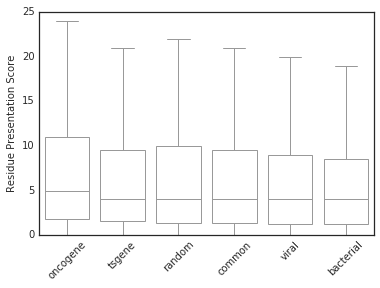

In [7]:
ax = sns.boxplot(x='category', y='best_rank', data=plotting, showfliers=False, color='white')
ax.grid(False)
plt.ylabel('Residue Presentation Score')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylim(0, 25)

## Panel B <br>
Data requirement: presentation score matrices for all peptide classes

In [8]:
perc_strong, perc_all, total_strong, total_all, total_count = [], [], [], [], []
for i, category in enumerate(categories):
    total = len(value_types[i])
    greater_than_strong = len(filter(lambda a: a < 0.5, value_types[i]))
    greater_than_all = len(filter(lambda a: a < 2, value_types[i]))
    total_strong.append(greater_than_strong)
    total_all.append(greater_than_all)
    total_count.append(total)
    print category, float(greater_than_all)/total, float(greater_than_strong)/total
    perc_all.append(float(greater_than_all)/total)
    perc_strong.append(float(greater_than_strong)/total)

oncogenes 0.261888904889 0.0743529051768
tsgenes 0.296071917139 0.072024623803
random 0.317438554492 0.0936664386685
common 0.325530437756 0.0964914500684
viral 0.330242818057 0.0985441176471
bacterial 0.337079685363 0.0993201094391


In [9]:
binders = pd.DataFrame({'category': categories, 'Perc_strong': perc_strong, 'Perc_all': perc_all})

In [10]:
binders['strong_from_r'] = ((binders.Perc_strong - float(binders[binders.category == 'random'].Perc_strong))/float(binders[binders.category == 'random'].Perc_strong)) * 100
binders['all_from_r'] = ((binders.Perc_all - float(binders[binders.category == 'random'].Perc_all))/float(binders[binders.category == 'random'].Perc_all)) * 100

In [11]:
all_binders = pd.DataFrame({'category': list(binders.category) + list(binders.category),
                            'percentage': list(binders.Perc_all) + list(binders.Perc_strong),
                            'binding': ['rank < 2%' for x in list(binders.Perc_all)] + ['rank < 0.5%' for x in list(binders.Perc_strong)]})

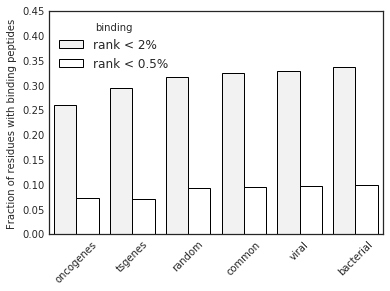

In [12]:
ax = sns.barplot(x='category', y='percentage', hue='binding', data=all_binders, order=['oncogenes', 'tsgenes', 'random', 'common', 'viral', 'bacterial'], color='white')
ax.grid(False)
plt.xticks(rotation=45)
plt.ylim(0, 0.45)
plt.ylabel('Fraction of residues with binding peptides')
plt.xlabel('')